# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The code cell below loads necessary Python libraries and the census data. The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

In [2]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data.income == ">50K"])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data.income == "<=50K"])

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/(n_greater_50k+n_at_most_50k)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often requires **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

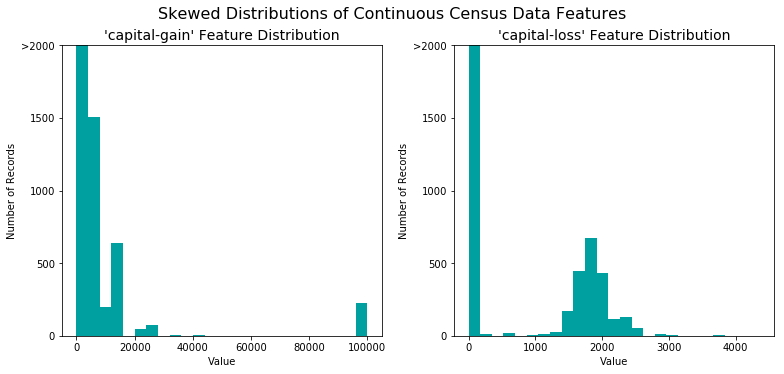

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

The code cell below performs a transformation on the data and visualizes the results. Note the range of values and how they are distributed. 

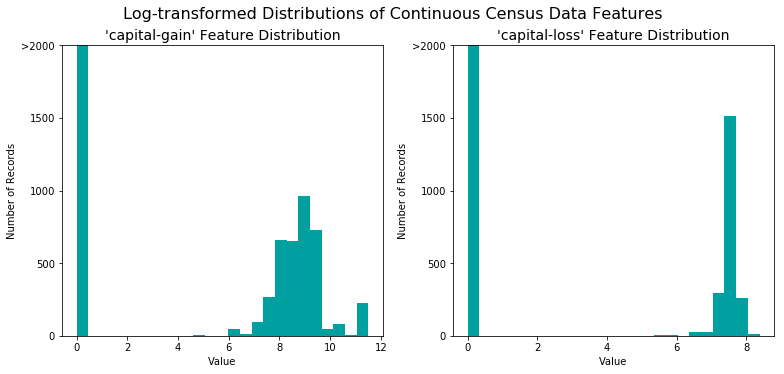

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners.

The code cell below normalizes each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, we will implement the following:
 - Perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate different algorithms, and determine which is best at modeling the data.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

In [8]:
# Calculate accuracy, precision and recall
accuracy = np.sum(income)/income.count()
recall = np.sum(income)/(np.sum(income)+income.count())
precision = np.sum(income)/(np.sum(income)+0)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.5**2) * (precision*recall) / ((0.5**2 * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.5534]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model, it's important to create a training and predicting pipeline that allows to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.
In the code block below, we will need to implement the following:
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, we will implement the following:
- Import the supervised learning models we've discussed in the previous section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
- Initialize the models with default settings and train them
- Visualize the results to choose the best performing model

KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


/Users/beko/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


/Users/beko/Documents/AIND/ML-Donors-Finder/visuals.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
/Users/beko/Documents/AIND/ML-Donors-Finder/visuals.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].set_xticks([0.45, 1.45, 2.45])
/Users/beko/Documents/AIND/ML-Donors-Finder/visuals.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].set_xticklabels(["1%", "10%", "100%"])
/Users/beko/Documents/AIND/ML-Donors-Finder/visuals.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].set_xlabel("Training Set Size")
/Users/beko/Documents/AIND/ML-Donors-Finder/visuals.py:79: V

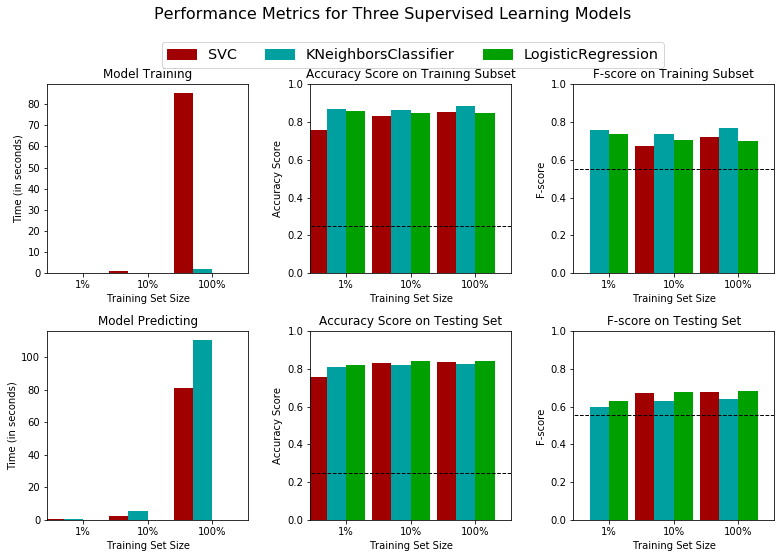

SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.
SGDClassifier trained on 36177 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.


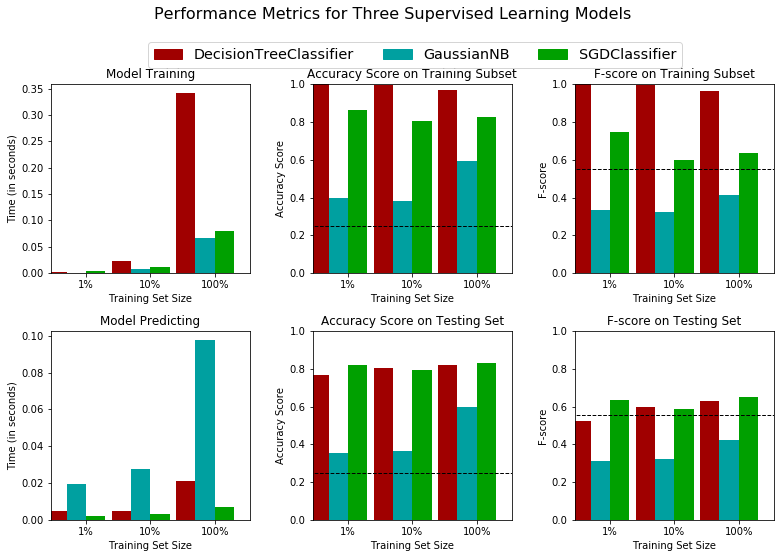

GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


/Users/beko/Documents/AIND/ML-Donors-Finder/visuals.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
/Users/beko/Documents/AIND/ML-Donors-Finder/visuals.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].set_xticks([0.45, 1.45, 2.45])
/Users/beko/Documents/AIND/ML-Donors-Finder/visuals.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].set_xticklabels(["1%", "10%", "100%"])
/Users/beko/Documents/AIND/ML-Donors-Finder/visuals.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[j/3, j%3].set_xlabel("Training Set Size")
/Users/beko/Documents/AIND/ML-Donors-Finder/visuals.py:79: V

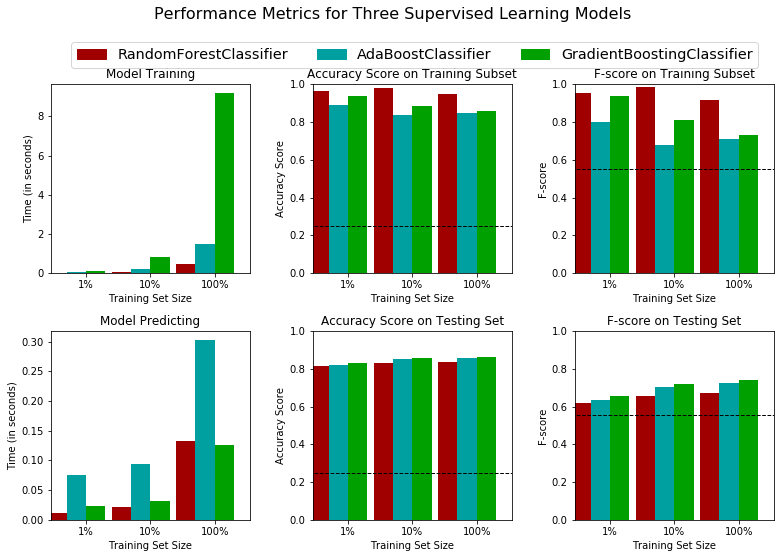

In [16]:
# Import the three supervised learning models from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# Collect results on the first three learners
results = {}
for clf in [KNeighborsClassifier(), LogisticRegression(), SVC()]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

# Collect results on the second three learners
results = {}
for clf in [SGDClassifier(), GaussianNB(), DecisionTreeClassifier()]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

# Collect results on the learners
results = {}
for clf in [GradientBoostingClassifier(), RandomForestClassifier(), AdaBoostClassifier()]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)   
# Run metrics visualization for the last three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model

According to the graphs the best results were shown by Gradient Boosting Classifier algorithm

### Implementation: Model Tuning
We will fine tune the chosen model using grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this.

In [12]:
# Import 'GridSearchCV', 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = GradientBoostingClassifier()

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'loss': ['deviance', 'exponential'], 'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.01]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8697
Final F-score on the testing data: 0.7498


**Results: ** We slightly improved our model perfomance by fine tuning it

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Implementation - Extracting Feature Importance

In the code cell below, we will extract the feature importances using our trained model's `'.feature_importances_'`.

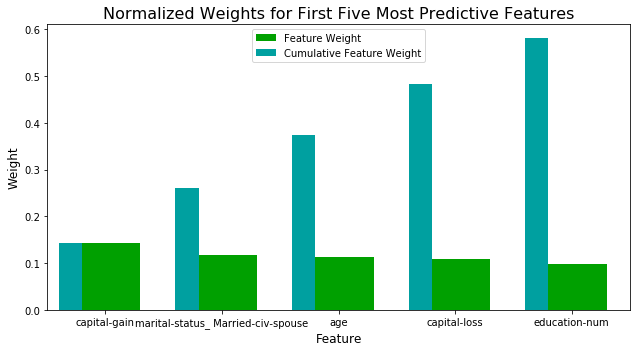

In [13]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8697
F-score on testing data: 0.7498

Final Model trained on reduced data
------
Accuracy on testing data: 0.8583
F-score on testing data: 0.7240


### Effects of Feature Selection

With only five features we got almost the same results and dramatically decreased our training times